In [41]:
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
me.init_vprinting()

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_interactions import ipyplot as iplt

import control as ct
from control.matlab import *
import scipy.linalg

# %%
# Specify the equations of motion
# -------------------------------
#
# The model is constructed using several constant parameters:
#
# - :math:`h`: distance mass center is from the ground contact line
# - :math:`a`: longitudinal distance of the mass center from the rear contact
# - :math:`b`: wheelbase length
# - :math:`g`: acceleration due to gravity
# - :math:`m`: mass of bicycle and rider
# - :math:`I_1`: roll principle moment of inertia
# - :math:`I_2`: pitch principle moment of inertia
# - :math:`I_3`: yaw principle moment of inertia
h, a, b, g = sm.symbols('h a, b, g', real=True)
m, I1, I2, I3 = sm.symbols('m, I1, I2, I3', real=True)
CaP, CaR = sm.symbols('CaP, CaR', real=True)

q1, q2, q3, q4, q5 = me.dynamicsymbols('q1, q2, q3, q4, q5', real=True)
u1, u2, u3, u4, u5 = me.dynamicsymbols('u1, u2, u3, u4, u5', real=True)
t = me.dynamicsymbols._t

q = sm.Matrix([q1, q2, q3, q4])
u = sm.Matrix([u1, u2, u3, u4])
p = sm.Matrix([h, a, b, g, m, I1, I2, I3, CaP, CaR])
r = sm.Matrix([q5, u5])
qd = q.diff(t)
qdd = qd.diff(t)

N, A, B, C = sm.symbols('N, A, B, C', cls=me.ReferenceFrame)
O, P, Q, R, S = sm.symbols('O, P, Q, R, S',  cls=me.Point)

A.orient_axis(N, q3, N.z)
B.orient_axis(A, q4, A.x)
C.orient_axis(A, q5, A.z)

P.set_pos(O, q1*N.x + q2*N.y)
Q.set_pos(P, a*A.x)
R.set_pos(P, b*A.x)
S.set_pos(Q, h*B.z)

A.set_ang_vel(N, u3*N.z)
B.set_ang_vel(A, u4*A.x)
C.set_ang_vel(A, u5*A.z)

O.set_vel(N, 0)
P.set_vel(N, u1*N.x + u2*N.y)
Q.v2pt_theory(P, N, A)
R.v2pt_theory(P, N, A)
S.v2pt_theory(Q, N, B)

IB = me.Inertia.from_inertia_scalars(S, B, I1, I2, I3)

bike_body = me.RigidBody('bike', S, B, m, IB)

alphaP = sm.atan(P.vel(N).dot(A.y) / P.vel(N).dot(A.x))
alphaR = sm.atan(R.vel(N).dot(C.y) / R.vel(N).dot(C.x))

gravity = me.Force(S, -m*g*N.z)
rear_tire = me.Force(P, -CaP*alphaP*A.y)
front_tire = me.Force(R, -CaR*alphaR*C.y)

kane = me.KanesMethod(
    N,
    (q1, q2, q3, q4),
    (u1, u2, u3, u4),
    kd_eqs=(u1 - q1.diff(t),
            u2 - q2.diff(t),
            u3 - q3.diff(t),
            u4 - q4.diff(t),)
)

kane.kanes_equations(bodies=(bike_body,),
                     loads=(gravity, front_tire, rear_tire))

eval_eom = sm.lambdify((q, u, r, p),
                       (kane.mass_matrix_full, kane.forcing_full))

eval_slip = sm.lambdify((q, u, r, p), (alphaP, alphaR))


In [42]:
Md_slip = kane.mass_matrix_full[-4:, -4:] # extract the bottom 4 right side rows and columns because the top left is FK
# gd = kane.forcing_full[-4:] # extract the last 4 entries because they are gd # idk whty but this didnt work so I got each term and made a matrix
gd_slip = sm.Matrix([kane.forcing_full[4], kane.forcing_full[5], kane.forcing_full[6], kane.forcing_full[7]])
me.find_dynamicsymbols(Md_slip), me.find_dynamicsymbols(gd_slip)

u2d = {u1: q1.diff(t), u2:q2.diff(t), u3: q3.diff(t), u4: q4.diff(t)}
gd_slip = gd_slip.xreplace(u2d)
me.find_dynamicsymbols(Md_slip), me.find_dynamicsymbols(gd_slip)


EOM_slip = Md_slip * qdd + gd_slip

dq4, dq4dot = sm.symbols('delta_q4 delta_q4dot')

xe_repl = {
    q1 : 0,
    q2 : 0,
    q3 : 0,
    q4 : 0,
    q5 : 0,
    q1.diff(t) : 5*sm.cos(q3),
    q2.diff(t) : 5*sm.sin(q3),
    q3.diff(t) : 0,
    q4.diff(t) : 0,
    q5.diff(t) : 0,
    q1.diff(t).diff(t) : 0,
    q2.diff(t).diff(t) : 0,
    q3.diff(t).diff(t) : 0,
    q4.diff(t).diff(t) : 0,
    q5.diff(t).diff(t) : 0,
 }

x = sm.Matrix([
    q1,
    q2,
    q3,
    q4,
    q5,
    q1.diff(t),
    q2.diff(t),
    q3.diff(t),
    q4.diff(t),
    q5.diff(t),
    q1.diff(t).diff(t),
    q2.diff(t).diff(t),
    q3.diff(t).diff(t),
    q4.diff(t).diff(t),
    q5.diff(t).diff(t),
])

xe = sm.Matrix([
    0,
    0,
    0,
    0,
    0,
    5*sm.cos(q3),
    5*sm.sin(q3),
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
])


f_lin_slip = EOM_slip.subs(xe_repl) + EOM_slip.jacobian(x).subs(xe_repl) @ (x - xe)
sm.trigsimp(f_lin_slip)

qdd_L = sm.Matrix([q1.diff(t).diff(t), q2.diff(t).diff(t), q3.diff(t).diff(t), q4.diff(t).diff(t)])
# Solve the system of equations for accelerationsI have more 
solutions = sm.solve(f_lin_slip, (qdd_L))
solutions
EOM_slip.jacobian(x).subs(xe_repl) @ (x - xe), EOM_slip.subs(xe_repl), sm.trigsimp(f_lin_slip), solutions



⎛⎡                                              m⋅q₁̈                           ↪
⎜⎢                                                                             ↪
⎜⎢  CaR⋅b⋅q₃̇                                     ⎛  CaP   CaR⎞                 ↪
⎜⎢- ──────── + CaR⋅q₅ + a⋅m⋅q₃̈ - h⋅m⋅q₄̈ + m⋅q₂̈ + ⎜- ─── - ───⎟⋅(-5⋅sin(q₃) + q ↪
⎜⎢     5                                         ⎝   5     5 ⎠                 ↪
⎜⎢                                                                             ↪
⎜⎢       2                                                                     ↪
⎜⎢  CaR⋅b ⋅q₃̇   CaR⋅b⋅(-5⋅sin(q₃) + q₂̇)                                        ↪
⎜⎢- ───────── - ─────────────────────── + CaR⋅b⋅q₃ + CaR⋅b⋅q₅ - a⋅h⋅m⋅q₄̈ + a⋅m ↪
⎜⎢      5                  5                                                   ↪
⎜⎢                                                                             ↪
⎜⎢                                                         ⎛      2  ⎞         ↪
⎝⎣                  

In [43]:
########## Getting state space of my system #################

# Convert to equations
solutions_matrix = sm.Matrix([solutions[q] for q in qdd_L])

q1_ddot = solutions_matrix[0]
q2_ddot = solutions_matrix[1]
q3_ddot = solutions_matrix[2]
q4_ddot = solutions_matrix[3]

# State derivatives
state_derivative = sm.Matrix([q4.diff(t), q4_ddot]) # q3.diff(t), q3_ddot,

# Input vector
input_vector = sm.Matrix([q5])
x = sm.Matrix([ q4, q4.diff(t)]) # where q5 is lean q3, q3.diff(t), 

# Compute A matrix: partial derivatives of state_derivative w.r.t. state
A = state_derivative.jacobian(x)

# Compute B matrix: partial derivatives of state_derivative w.r.t. input
B = state_derivative.jacobian(input_vector)
B

x0 = np.array([
    # 0.0,
    # 0.0,
    # 0.0,
    np.deg2rad(10.0),#lean
    # 4.0,# vel in
    0.0,
    # 0.0,
    # 0.0,
])

p_vals = np.array([
    1.0,  # h [m]
    0.5,  # a [m]
    1.0,  # b [m]
    9.81,  # g [m/s^2]
    87.0,  # m [kg]
    9.2,  # I1 [kg m^2]
    11.0,  # I2 [kg m^2]
    2.8,  # I3 [kg m^2]
    3600.0,  # CaP
    3600.0,  # CaR
])

# Compute A matrix: partial derivatives of state_derivative w.r.t. state
eval_A = sm.lambdify((p), A)
eval_B = sm.lambdify((p), B)

A_val = eval_A(*p_vals,)
B_val = eval_B(*p_vals,)

from numpy.linalg import matrix_rank

# Build controllability matrix
n = A_val.shape[0]
controllability_matrix = np.hstack([np.linalg.matrix_power(A_val, i) @ B_val for i in range(n)])

# Check rank
controllability_rank = matrix_rank(controllability_matrix)
print("Controllability Rank:", controllability_rank)

if controllability_rank < n:
    print("System is not controllable.")
else:
    print("System is controllable.")
type(controllability_matrix)

Controllability Rank: 2
System is controllable.


numpy.ndarray

[[-6.83796596 -2.24386934]]


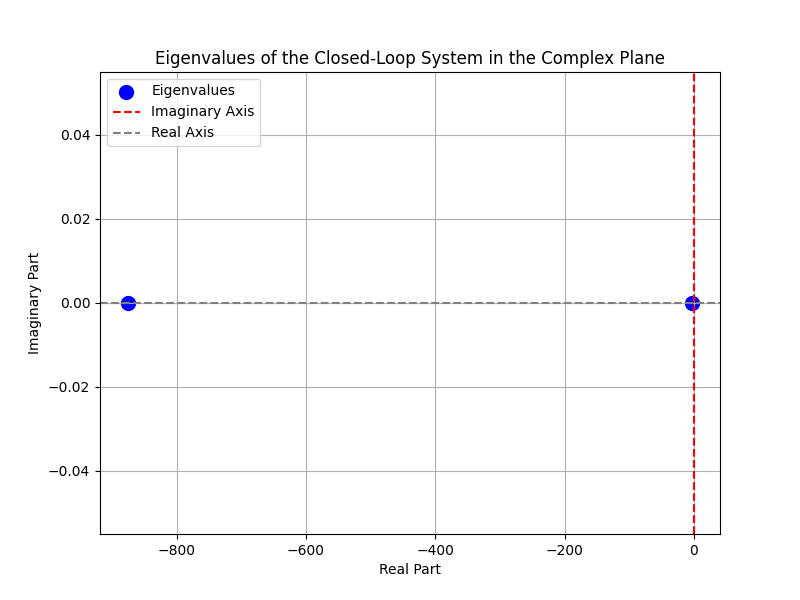

array([  -3.16445867, -874.87136905])

In [44]:
# Define the cost matrices Q and R
Q = np.diag([100, 10])  # Penalty on states same size as A ( theta and theta dot)
R = np.diag([2])  # Penalize steering (input) effort same size as B (delta and delta_dot) and square, and numerically singular

# Step 4: Solve the continuous-time algebraic Riccati equation (CARE) to get the optimal gain matrix K
# P is the solution to the Riccati equation
P = scipy.linalg.solve_continuous_are(A_val, B_val, Q, R)
# the LQR gains matrix
K = np.linalg.inv(R) @ B_val.T @ P
u = [q5]
print(K)

# Closed-loop system matrix
A_cl = A_val - B_val @ K

import numpy as np
from numpy.linalg import eig

# # closed loop poles!!!!
# eigenvalues = eig(A_cl)

# # print("Shape of A:", A_val.shape)
# # print("Shape of B:", B_val.shape)
# # print("Shape of K:", K.shape)

# get eig val and vec seperately
[eig_val, eig_vec] = eig(A_cl)
eig_val

# get real and imag pts
real_parts = np.real(eig_val)
imag_parts = np.imag(eig_val)

# Plot eigvals
plt.figure(figsize=(8, 6))
plt.scatter(real_parts, imag_parts, color='blue', marker='o', s=100, label='Eigenvalues')
plt.axvline(0, color='red', linestyle='--', label='Imaginary Axis')  # Vertical line at Re=0
plt.axhline(0, color='gray', linestyle='--', label='Real Axis')     # Horizontal line at Im=0

# make plot readable
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues of the Closed-Loop System in the Complex Plane')
plt.legend()
plt.grid(True)
plt.show()

eig_val, A_val, B_val
# A_val.shape
# A_cl.shape
# B_val.shape
real_parts

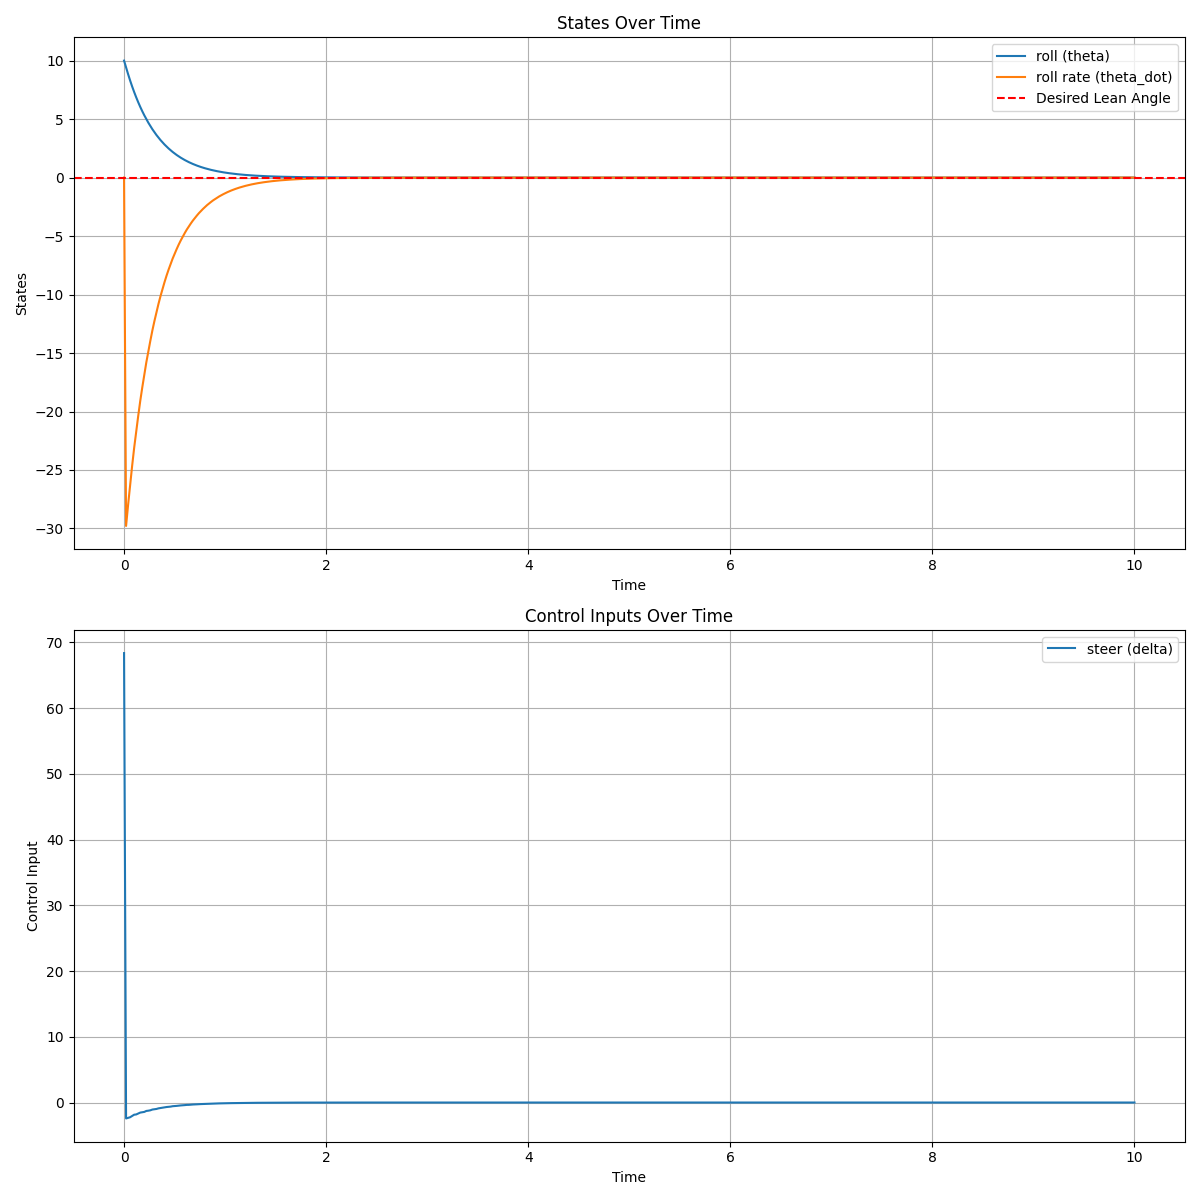

In [45]:
import numpy as np
import sympy as sm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Assuming R, B, P, A_val, B_val, x0, and p_vals are defined elsewhere in your code
K = np.linalg.inv(R) @ B.T @ P  # LQR gain matrix
eval_K = sm.lambdify((p), K)
K_val = eval_K(*p_vals)

# Desired lean angle in degrees
theta_des = 0
  # this is my reference state 

# Define the closed-loop dynamics
def closed_loop_dynamics(t, x):
    x_des = np.array([np.deg2rad(theta_des), 0])  # Desired state
    dx = (A_val - B_val @ K_val) @ x + B_val @ K_val @ x_des  # Closed-loop dynamics
    return dx

# Time span for simulation
t_span = (0, 10)  # Simulate from t=0 to t=10
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Time points for evaluation

# Simulate the closed-loop system
sol = solve_ivp(closed_loop_dynamics, t_span, x0, t_eval=t_eval)

# Extract the states over time
x_t = sol.y  # States over time
t = sol.t    # Time points

# Compute the control input over time
x_des = np.array([np.deg2rad(theta_des), 0])  # Desired state
u_t = -K_val @ (x_t - x_des.reshape(-1, 1))  # Control input

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the states over time in the first subplot
ax1.plot(t, np.rad2deg(x_t[0]), label="roll (theta)")
ax1.plot(t, np.rad2deg(x_t[1]), label="roll rate (theta_dot)")
ax1.axhline(theta_des, color='r', linestyle='--', label="Desired Lean Angle")
ax1.set_xlabel("Time")
ax1.set_ylabel("States")
ax1.set_title("States Over Time")
ax1.legend()
ax1.grid(True)

# Plot the control inputs over time in the second subplot
ax2.plot(t, np.rad2deg(u_t[0]), label="steer (delta)")
# ax2.plot(t, np.rad2deg(u_t[1]), label="steer rate (delta_dot)")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control Input")
ax2.set_title("Control Inputs Over Time")
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

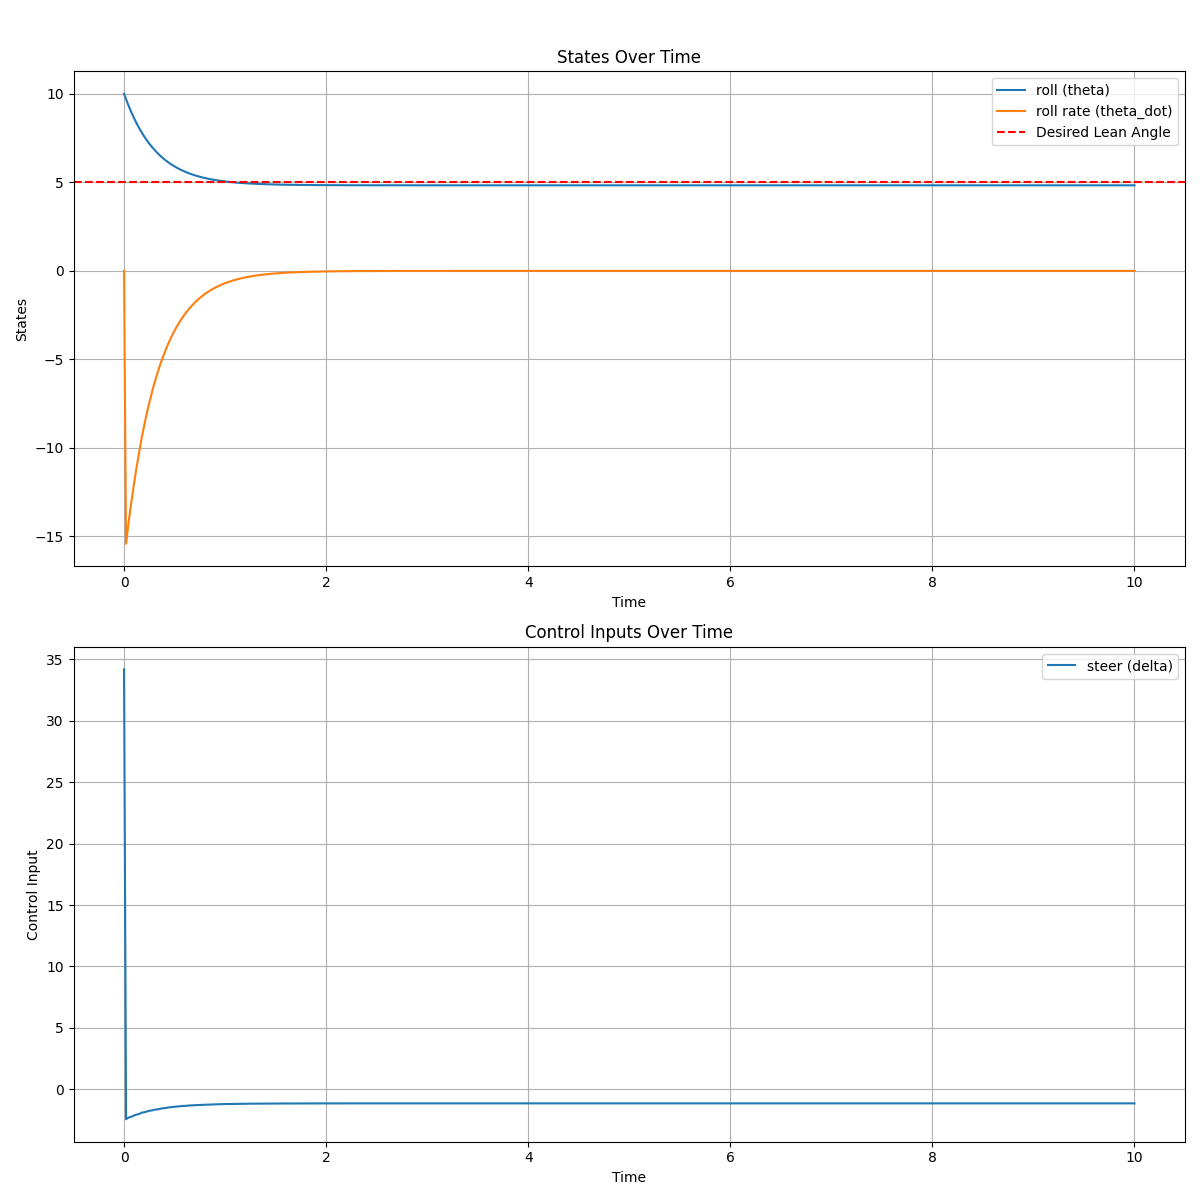

In [46]:
import numpy as np
import sympy as sm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Assuming R, B, P, A_val, B_val, x0, and p_vals are defined elsewhere in your code
K = np.linalg.inv(R) @ B.T @ P  # LQR gain matrix
eval_K = sm.lambdify((p), K)
K_val = eval_K(*p_vals)
# K_val = 2 * K_val  # Increase the gain (adjust the factor as needed)

# Desired lean angle in degrees
theta_des = 5
  # this is my reference state 

# Calculate the feedforward control input
u_ff = np.linalg.pinv(B_val) @ (x_des - A_val @ x_des)

def closed_loop_dynamics(t, x):
    x_des = np.array([np.deg2rad(theta_des), 0])  # Desired state
    u_fb = -K_val @ (x - x_des)  # Feedback control input
    u = u_fb + u_ff  # Total control input
    dx = A_val @ x + B_val @ u  # System dynamics
    return dx

# Time span for simulation
t_span = (0, 10)  # Simulate from t=0 to t=10
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Time points for evaluation

# Simulate the closed-loop system
sol = solve_ivp(closed_loop_dynamics, t_span, x0, t_eval=t_eval)

# Extract the states over time
x_t = sol.y  # States over time
t = sol.t    # Time points

# Compute the control input over time
x_des = np.array([np.deg2rad(theta_des), 0])  # Desired state
u_t = -K_val @ (x_t - x_des.reshape(-1, 1))  # Control input

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Add main title for the entire figure
fig.suptitle('LQR Controller Performance: Lean Angle and Steering Input', 
             fontsize=14, fontweight='bold', y=1.02)

# Plot the states over time in the first subplot
ax1.plot(t, np.rad2deg(x_t[0]), label="roll (theta)")
ax1.plot(t, np.rad2deg(x_t[1]), label="roll rate (theta_dot)")
ax1.axhline(theta_des, color='r', linestyle='--', label="Desired Lean Angle")
ax1.set_xlabel("Time")
ax1.set_ylabel("States")
ax1.set_title("States Over Time")
ax1.legend()
ax1.grid(True)

# Plot the control inputs over time in the second subplot
ax2.plot(t, np.rad2deg(u_t[0]), label="steer (delta)")
# ax2.plot(t, np.rad2deg(u_t[1]), label="steer rate (delta_dot)")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control Input")
ax2.set_title("Control Inputs Over Time")
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

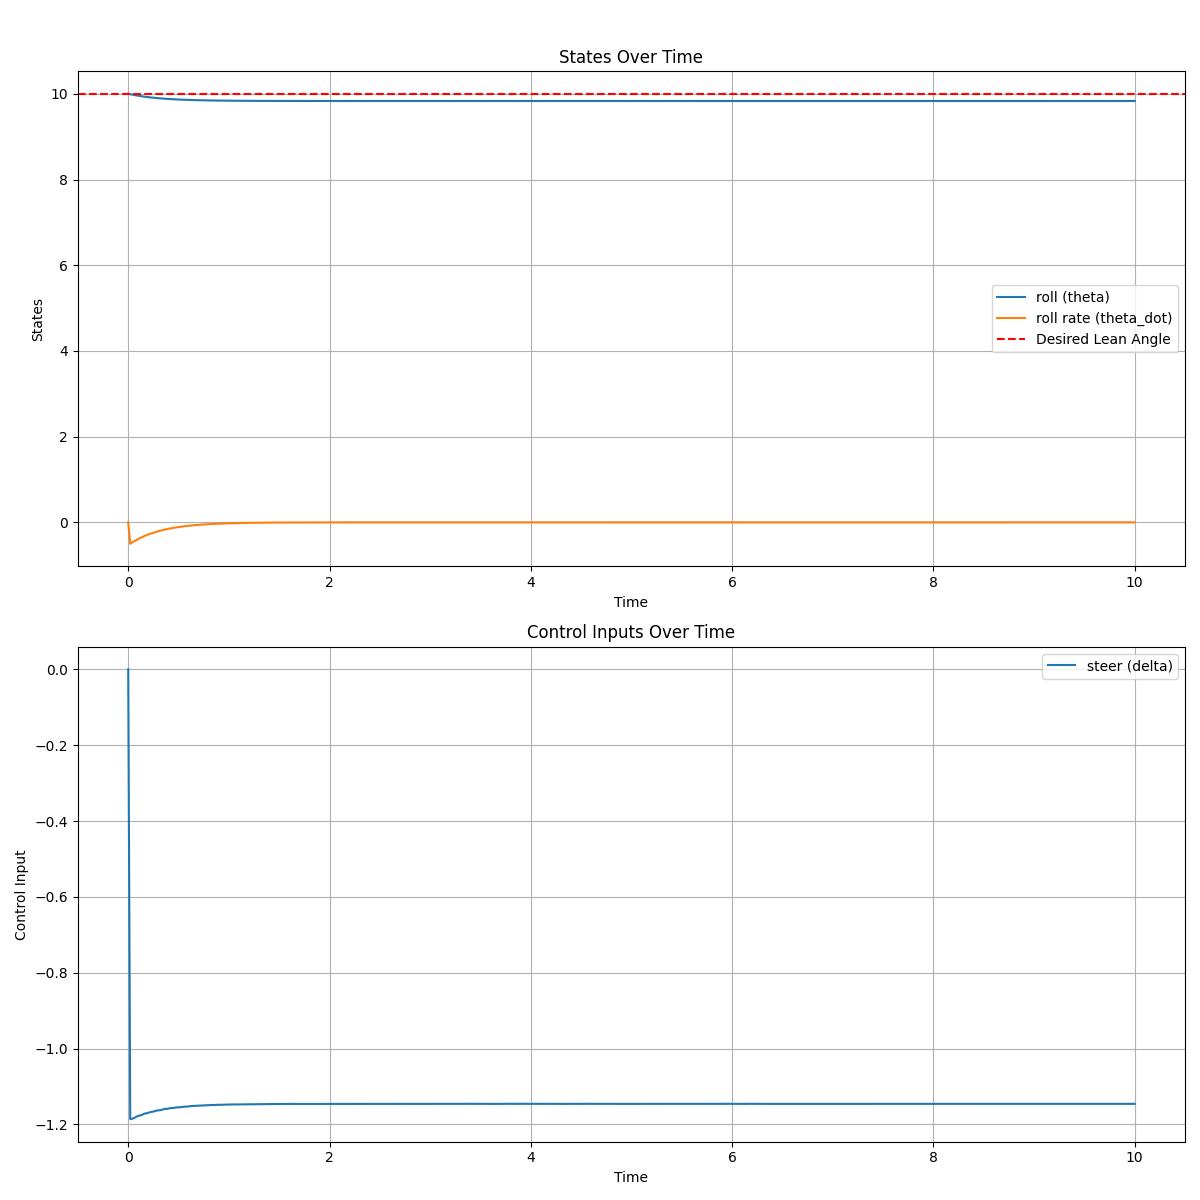

In [47]:
import numpy as np
import sympy as sm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Assuming R, B, P, A_val, B_val, x0, and p_vals are defined elsewhere in your code
K = np.linalg.inv(R) @ B.T @ P  # LQR gain matrix
eval_K = sm.lambdify((p), K)
K_val = eval_K(*p_vals)
# K_val = 2 * K_val  # Increase the gain (adjust the factor as needed)

# Desired lean angle in degrees
theta_des = 10
  # this is my reference state 

# Calculate the feedforward control input
u_ff = np.linalg.pinv(B_val) @ (x_des - A_val @ x_des)

def closed_loop_dynamics(t, x):
    x_des = np.array([np.deg2rad(theta_des), 0])  # Desired state
    u_fb = -K_val @ (x - x_des)  # Feedback control input
    u = u_fb + u_ff  # Total control input
    dx = A_val @ x + B_val @ u  # System dynamics
    return dx

# Time span for simulation
t_span = (0, 10)  # Simulate from t=0 to t=10
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Time points for evaluation

# Simulate the closed-loop system
sol = solve_ivp(closed_loop_dynamics, t_span, x0, t_eval=t_eval)

# Extract the states over time
x_t = sol.y  # States over time
t = sol.t    # Time points

# Compute the control input over time
x_des = np.array([np.deg2rad(theta_des), 0])  # Desired state
u_t = -K_val @ (x_t - x_des.reshape(-1, 1))  # Control input

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Add main title for the entire figure
fig.suptitle('LQR Controller Performance: Lean Angle and Steering Input', 
             fontsize=14, fontweight='bold', y=1.02)

# Plot the states over time in the first subplot
ax1.plot(t, np.rad2deg(x_t[0]), label="roll (theta)")
ax1.plot(t, np.rad2deg(x_t[1]), label="roll rate (theta_dot)")
ax1.axhline(theta_des, color='r', linestyle='--', label="Desired Lean Angle")
ax1.set_xlabel("Time")
ax1.set_ylabel("States")
ax1.set_title("States Over Time")
ax1.legend()
ax1.grid(True)

# Plot the control inputs over time in the second subplot
ax2.plot(t, np.rad2deg(u_t[0]), label="steer (delta)")
# ax2.plot(t, np.rad2deg(u_t[1]), label="steer rate (delta_dot)")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control Input")
ax2.set_title("Control Inputs Over Time")
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

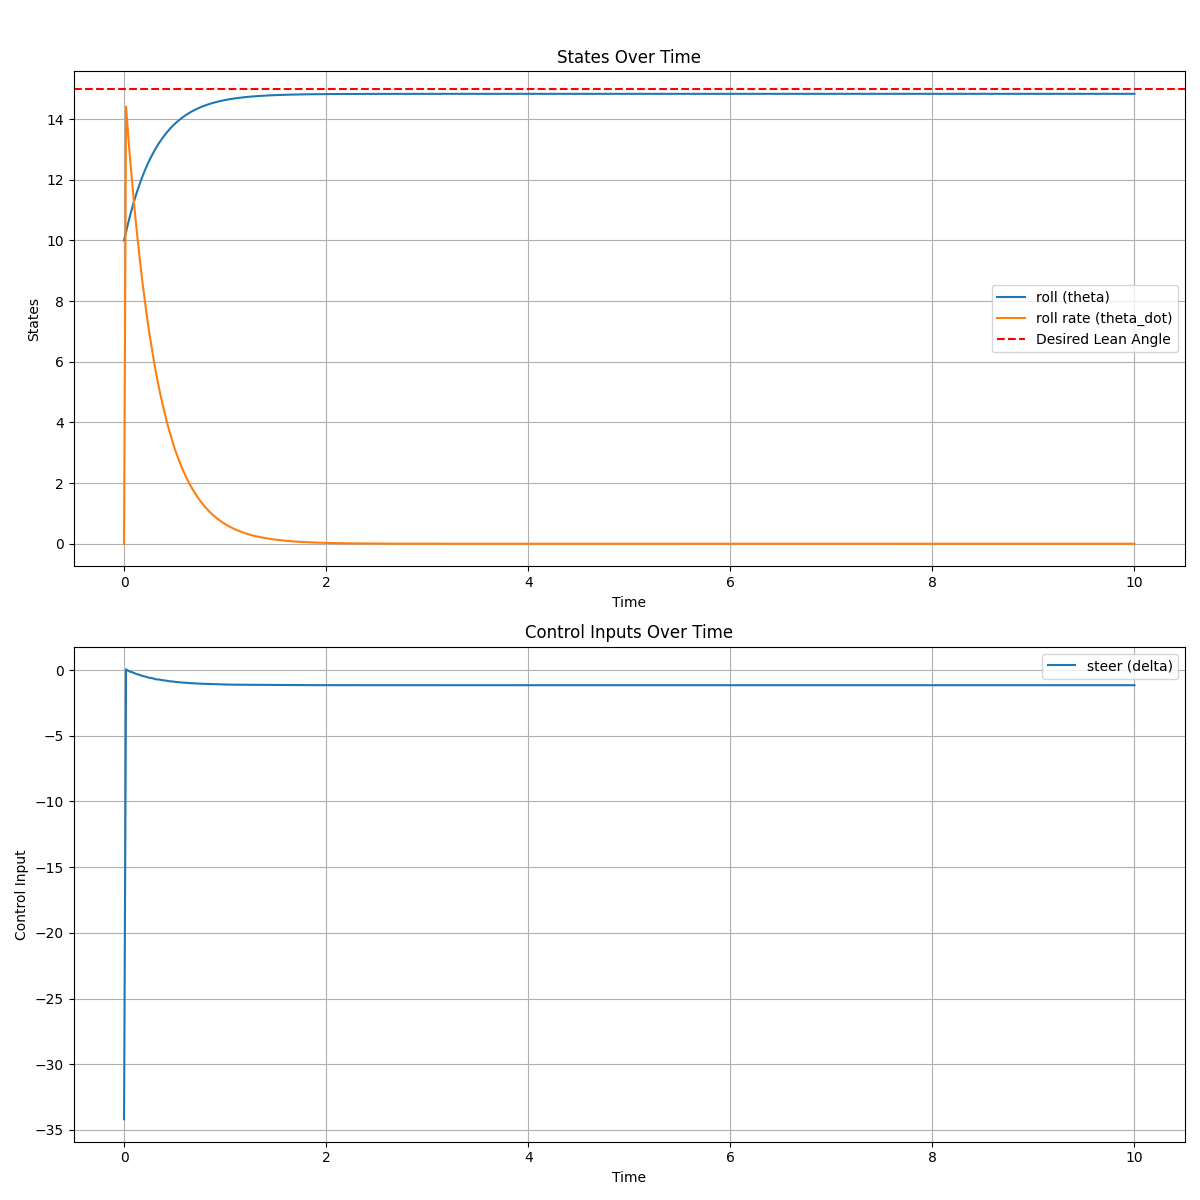

In [48]:
import numpy as np
import sympy as sm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Assuming R, B, P, A_val, B_val, x0, and p_vals are defined elsewhere in your code
K = np.linalg.inv(R) @ B.T @ P  # LQR gain matrix
eval_K = sm.lambdify((p), K)
K_val = eval_K(*p_vals)
# K_val = 2 * K_val  # Increase the gain (adjust the factor as needed)

# Desired lean angle in degrees
theta_des = 15
  # this is my reference state 

# Calculate the feedforward control input
u_ff = np.linalg.pinv(B_val) @ (x_des - A_val @ x_des)

def closed_loop_dynamics(t, x):
    x_des = np.array([np.deg2rad(theta_des), 0])  # Desired state
    u_fb = -K_val @ (x - x_des)  # Feedback control input
    u = u_fb + u_ff  # Total control input
    dx = A_val @ x + B_val @ u  # System dynamics
    return dx

# Time span for simulation
t_span = (0, 10)  # Simulate from t=0 to t=10
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Time points for evaluation

# Simulate the closed-loop system
sol = solve_ivp(closed_loop_dynamics, t_span, x0, t_eval=t_eval)

# Extract the states over time
x_t = sol.y  # States over time
t = sol.t    # Time points

# Compute the control input over time
x_des = np.array([np.deg2rad(theta_des), 0])  # Desired state
u_t = -K_val @ (x_t - x_des.reshape(-1, 1))  # Control input

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Add main title for the entire figure
fig.suptitle('LQR Controller Performance: Lean Angle and Steering Input', 
             fontsize=14, fontweight='bold', y=1.02)

# Plot the states over time in the first subplot
ax1.plot(t, np.rad2deg(x_t[0]), label="roll (theta)")
ax1.plot(t, np.rad2deg(x_t[1]), label="roll rate (theta_dot)")
ax1.axhline(theta_des, color='r', linestyle='--', label="Desired Lean Angle")
ax1.set_xlabel("Time")
ax1.set_ylabel("States")
ax1.set_title("States Over Time")
ax1.legend()
ax1.grid(True)

# Plot the control inputs over time in the second subplot
ax2.plot(t, np.rad2deg(u_t[0]), label="steer (delta)")
# ax2.plot(t, np.rad2deg(u_t[1]), label="steer rate (delta_dot)")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control Input")
ax2.set_title("Control Inputs Over Time")
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()